# Multiple Linear Regression - Systolic Blood Pressure

In [71]:
from data.create_data import *
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [9]:
data = read_frmgham()
clean_data = data.dropna(subset=['cigpday', 'sysbp', 'age'])
cigpday = clean_data.cigpday
sysbp = clean_data.sysbp
age = clean_data.age

### Research Questions
  1. Does the effect of the *number of cigerattes smoked per day* (`cigpday`) on systolic blood pressures change if we control for *age* (`age`)?
  2. Likewise, does the effect of *age* (`age`) on blood pressure change if we control for `cigpday`?

## Exploratory Data Analyses

### Histogram
View the distributions of the variables.

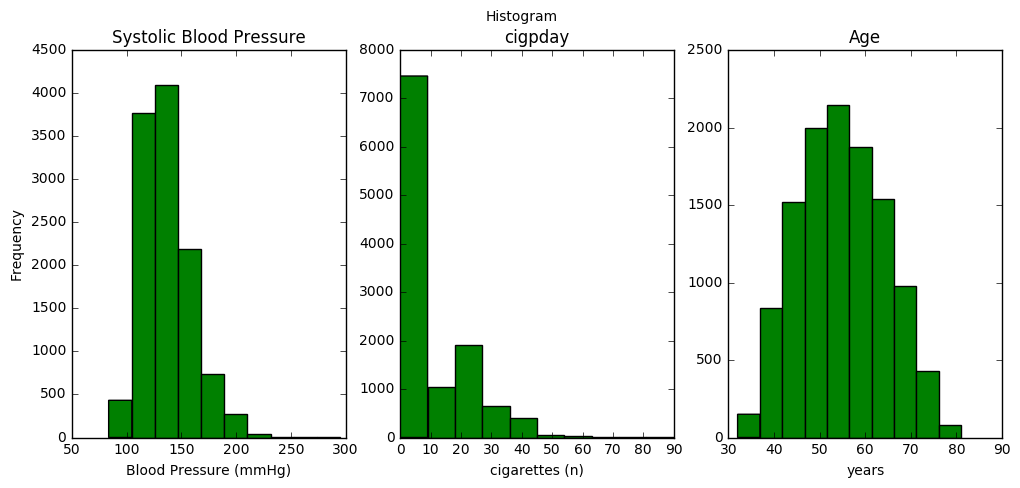

In [67]:
plt.figure(figsize=(12, 5))
plt.subplot(1,3,1)
plt.hist(sysbp, color='g')
plt.title("Systolic Blood Pressure")
plt.xlabel('Blood Pressure (mmHg)')
plt.ylabel('Frequency')

plt.subplot(1,3,2)
plt.hist(cigpday, color='g', bins=10)
plt.title("cigpday")
plt.xlabel('cigarettes (n)')
plt.legend(loc='upper right')

plt.subplot(1,3,3)
plt.hist(age, color='g')
plt.title("Age")
plt.xlabel('years')
plt.suptitle('Histogram')

plt.show()

In [66]:
clean_data[['sysbp','cigpday', 'age']].describe()

,sysbp,cigpday,age
count,11548.000000,11548.000000,11548.000000
mean,136.315812,8.250346,54.795809
std,22.766478,12.186888,9.564441
min,83.500000,0.000000,32.000000
25%,120.000000,0.000000,48.000000
50%,132.000000,0.000000,54.000000
75%,149.000000,20.000000,62.000000
max,295.000000,90.000000,81.000000


##### Conclusions
  * **`sysbp`** has an approximately right/positive skewed distribution. The mean (136 mmHg) is greater than the median (132 mmHg)
  * **`cigpday`** has an approximately right skewed positive distribution, with a mean of 8 cigarettes and median of 0.
  * **`age`** has a normal distribution with a mean that is approximately equal to the median (54 years old).

### Scatter Plots
Scatter plots provide a general impression of the relationship between systolic blood pressure (`sysbp`) and cigarettes smoked per day (`cigpday`) as well as age (`age`) .

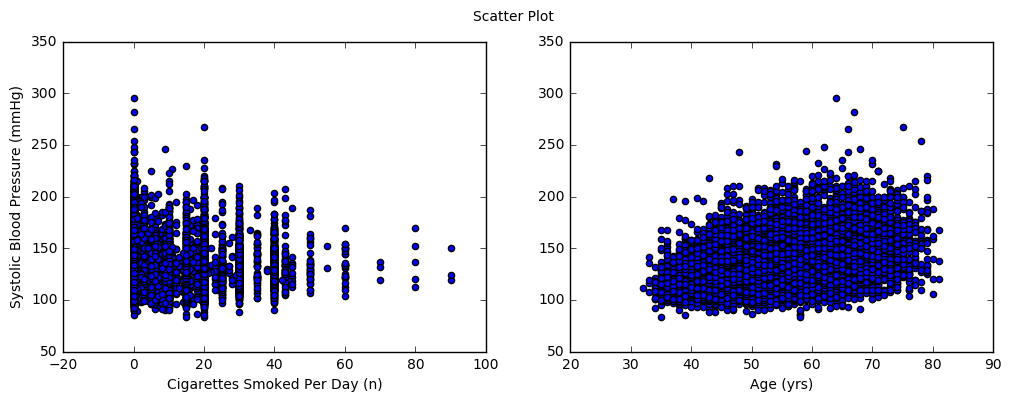

In [38]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.scatter(cigpday, sysbp)
plt.xlabel('Cigarettes Smoked Per Day (n)')
plt.ylabel('Systolic Blood Pressure (mmHg)')

plt.subplot(1,2,2)
plt.scatter(age, sysbp)
plt.xlabel('Age (yrs)')
# plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.suptitle('Scatter Plot')
plt.show()

#### *Jittered* Scatter Plots

Jittering is used for *visualization purposes only*. It minimizes the effect of losing information that's inherit with a scatter plot by adding random noise. The addition reverses the effect of rounding off. Thus, reducing the visual effect and makes relationship clearer.

In [29]:
def Jitter(values, jitter=0.5):
    """Jitters the values by adding a uniform variate in (-jitter, jitter).

    values: sequence
    jitter: scalar magnitude of jitter
    
    returns: new numpy array
    """
    n = len(values)
    return np.random.uniform(-jitter, +jitter, n) + values

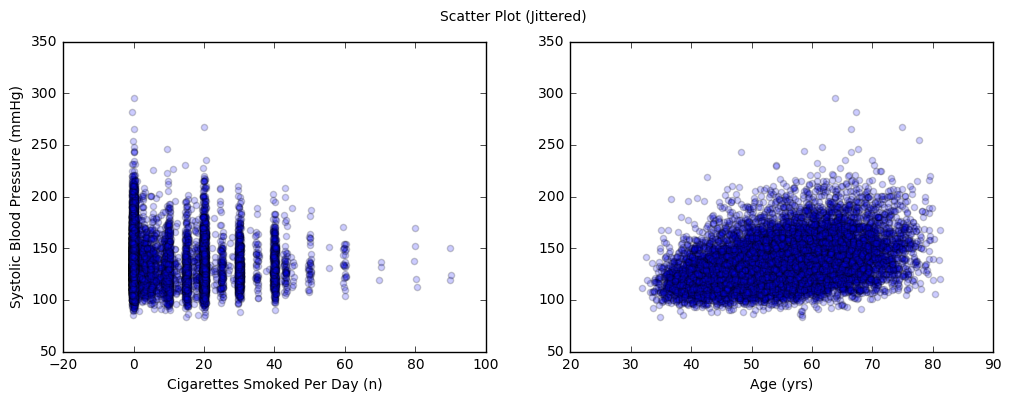

In [39]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.scatter(Jitter(cigpday), Jitter(sysbp), alpha = 0.2)
plt.xlabel('Cigarettes Smoked Per Day (n)')
plt.ylabel('Systolic Blood Pressure (mmHg)')

plt.subplot(1,2,2)
plt.scatter(Jitter(age), Jitter(sysbp), alpha=0.2)
plt.xlabel('Age (yrs)')
# plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.suptitle('Scatter Plot (Jittered)')
plt.show()

##### Conclusion

The plot shows no apparent relationships between systolic blood pressure and cigarettes smoked per day nor age.

**Drawbacks**: It should be noted that scatter plots are not the best representation of data since data are packed/binned into columns, losing specificity. As result, some information is lost in the translation.

### Bivariate Relationships
Analyze pair-wise relationships between `sysbp` and each of the predictor variables.  

#### Covariance
Covariance is the measure of tendency of `sysbp` to vary with the predictor variables together.

In [41]:
cov_cig_sysbp = np.cov(cigpday,sysbp)[0,1]
cov_age_sysbp = np.cov(age, sysbp) [0,1]

print "Covariance of sysbp & cigpday = %.2f" % cov_cig_sysbp
print "Covariance of sysbp & age= %.2f" % cov_age_sysbp

Covariance of sysbp & cigpday = -28.51
Covariance of sysbp & age= 84.73


##### Conclusion
  * The covariance of `cigpday` and `sysbp` has a value of -28.52 cigarettes-mmHg. The negative value indicates that the tendency between the 2 variables point in opposite directions.
  * A covariance value of 84.73 years-mmHg for `age` and `sysbp` indicates that the tendency of both variables point in the same direction.

##### Shortcomings
Covariance is seldom reported as a summary statistic due to the difficulties in its interpretation.

### Correlation
Correlation coefficients quantify the strength and relationship between `sysbp` and `cigpday` as well as `age`. 


They are essentially a *standardized version* of covariance (**standard scores**) that's much intuitive to interpret. They address the issue of inconsistency between the two variables being compared (e.g. different units or distributions between the variables) by transforming each value into a standard score. Thus, the set of values are normalized to have their mean at 0 and variance of 1.

### Pearson's Correlation
Pearson's correlation measures the *linear* relationship between variables. It expresses the value in standard deviations from the mean.

**Range**: [-1, +1]

In [50]:
pear_corr = data[['sysbp', 'cigpday', 'age']].corr(method='pearson')
print "Pearson's Coefficient (sysbp & cigpday) = %.3f" % pear_corr.loc['sysbp', 'cigpday']
print "Pearson's Coefficient (sysbp & age) = %.3f" % pear_corr.loc['sysbp', 'age']

Pearson's Coefficient (sysbp & cigpday) = -0.103
Pearson's Coefficient (sysbp & age) = 0.389


##### Conclusions
  * Pearson's Correlation Coefficent for `sysbp` and `cigpday` is -0.103, indicating a weak negative linear correlation.
  * Pearson's Correlation Coefficient for `sysbp` and `age` is 0.389, suggesting a relatively fair positive linear correlation.
  
##### Shortcomings
Pearson's correlation coefficient only measures linear relationships, thus its coefficient understates the strength for non-linear relationships. It also is not robust in the presence of outliers.

### Spearman's Correlation
Spearman's correlation measures the relationship between variables in terms of rank or order. The rank for each value is computed and is assigned as its index in the sorted sample.

It's much superior to Pearson at controlling the effects of outliers and skewed distributions.

In [51]:
spear_corr = data[['sysbp', 'cigpday', 'age']].corr(method='spearman')
print "Spearman's Coefficient (sysbp & cigpday) = %.3f" % spear_corr.loc['sysbp', 'cigpday']
print "Spearman's Coefficient (sysbp & age) = %.3f" % spear_corr.loc['sysbp', 'age']

Spearman's Coefficient (sysbp & cigpday) = -0.135
Spearman's Coefficient (sysbp & age) = 0.397


##### Conclusions
  * Spearman's Correlation Coefficent for `sysbp` and `cigpday` is -0.135, indicating very weak rank-order correlation.
  * Spearman's Correlation Coefficient for `sysbp` and `age` is 0.397, suggesting a relatively decent positive rank-order correlation.

**Note**: `cigpday` may have a poor Spearman's correlation coefficient with `sysbp` due to the fact that its data type is not ordinal.

##### Shortcomings
Spearman's rank correlation works best only if the relationship between the variable is linear and the variable's distribution are roughly normal. Thus, supporting the poor correlation between `sysbp` and `cigpday`, which has a fairly strong right right-skewed distribution.

# Multiple Linear Regression
Identify the relationships between the response (`sysbp`) and its various explanatory variables/predictors (`x`).

**`y = β`<sub>0</sub> ` + β`<sub>cigpday</sub> ` X`<sub>cigpday</sub>` + β`<sub>age</sub> ` X`<sub>age</sub>**

#### Predictor Variables (`X`)
  1. `cigpday`: number of cigarettes smoked per day
  2. `age`: age of patient/respondent
  
#### Response (`Y`)
  1. `sysbp`: mean systolic blood pressure (mmHg)

### Method: Ordinary Least Squares (Linear Least Squares Fit)
Identify a linear regression model that minimizes the sum of squares of the residuals. *Find the least squares fit*.

In [102]:
formula = 'sysbp ~ cigpday + age'
model = smf.ols(formula, data=clean_data)
results = model.fit()

results.params

Intercept    86.237689
cigpday      -0.027999
age           0.918120
dtype: float64

In [96]:
print "intercept = %.3f" % results.params['Intercept']
print "slope (cigpday) = %.3f" % results.params['cigpday']
print "slope (age) = %.3f" % results.params['age']

intercept = 86.238
slope (cigpday) = -0.028
slope (age) = 0.918


**Slopes**:
  * **β<sub>cigpday</sub>**: For a one unit increase in cigpday (*predictor<sub>1</sub>*), systolic blood pressure (*response*) decreases by 0.028 , *controlling all other predictors*.
  * **β<sub>age</sub>**: For a one unit increase in age (*predictor<sub>2</sub>*), systolic blood pressure (*response*) increases by 0.92, *controlling all other predictors*.

### Model Equation  
**`y = β`<sub>0</sub> ` - 0.028 X`<sub>cigpday</sub>` + 0.92 X`<sub>age</sub>**

## Hypothesis Test

### Effect of `cigpday` on `sysbp`

1) Hypothesis
  * **H<sub>0</sub>**: There is no effect of the number of cigarettes smoked per day (`cigpday`) on systolic blood pressure (`sysbp`), controlling for age (`age`).
  * **H<sub>A</sub>**: There is an effect of the number of cigarettes smoked per day (`cigpday`) on systolic blood pressure (`sysbp`), controlling for age (`age`).
  
2) Statistical Test
Compute the test statistic & p-value.
  * test statistic: **slope** (β<sub>cigpday</sub>)

In [101]:
print "slope (cigpday) = %.3f" % results.params['cigpday']
print "p-value (cigpday) = %.3f" % results.pvalues['cigpday']
print "95% CI = ", list(results.conf_int().loc['cigpday'])

slope (cigpday) = -0.028
p-value (cigpday) = 0.089
95% CI =  [-0.060235483278232915, 0.0042365751392417772]


3) Results
  * **β<sub>cigpday</sub>** = -0.028
  * **p-value** = 0.089  
  
The **p-value** is extremely large (p-val > 0.05), providing weak evidence against  the null hypothesis. Additionally, the **confidence interval** contains a slope (β<sub>cigpday</sub>) of 0. 

The null hypothesis is failed to be rejected, proving that there's no significant association between `cigpday` and `sysbp`, controlling for other predictors.

##### Conclusion
There is no effect of `cigpday` on `sysbp`. The difference or negative slope depicting the relationship between the two variables is irrelevant and is most likely due to chance.

#### Considerations
The previous hypothesis test conducted testing the effect of `cigpday` on `sysbp` using a **linear regression** model found that there is a significant association  between the predictor variable and response.

This indicates that `cigpday` in conjunction with `age` as a confounding predictor variable in a **multiple regression** model has a much different relationship.

### Effect of `age` on `sysbp`

1) Hypothesis
  * **H<sub>0</sub>**: There is no effect of age (`age`) on systolic blood pressure (`sysbp`), controlling for the number of cigarettes smoked per day (`cigpday`).
  * **H<sub>A</sub>**: There is an effect of age (`age`) on systolic blood pressure (`sysbp`), controlling for the number of cigarettes smoked per day (`cigpday`).
  
2) Statistical Test
Compute the test statistic & p-value.
  * test statistic: **slope** (β<sub>age</sub>)

In [105]:
print "slope (age) = %.3f" % results.params['age']
print "p-value (age) = %.3f" % results.pvalues['age']
print "95% CI = ", list(results.conf_int().loc['age'])

slope (age) = 0.918
p-value (age) = 0.000
95% CI =  [0.87704528032125961, 0.95919475445776192]


3) Results
  * **β<sub>age</sub>** = 0.92
  * **p-value** = 0  
  
The **p-value** is extremely small (p-val < 0.05), providing substantial evidence against  the null hypothesis. Additionally, the **confidence interval** does not contains a slope (β<sub>age</sub>) of 0. 

The null hypothesis is rejected, proving that there's a significant association between `age` and `sysbp`, controlling for other predictors.

##### Conclusion
There is an effect of `age` on `sysbp`. For each one unit increase in `age`, systolic blood pressure (`sysbp`) increases by 0.92, controlling for `cigpday`.

## Results Overview

In [130]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sysbp   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     1032.
Date:                Thu, 16 Mar 2017   Prob (F-statistic):               0.00
Time:                        16:29:39   Log-Likelihood:                -51527.
No. Observations:               11548   AIC:                         1.031e+05
Df Residuals:                   11545   BIC:                         1.031e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     86.2377      1.202     71.720      0.000        83.881    88.595
cigpday       -0.0280      0.016     -1.703      0.089        -0.060     0.004
age            0.9181      0.021     43.815      0.000         0.877     0.959
==============================================================================
Omnibus:                     1402.165   Durbin-Watson:                   1.218
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2381.097
Skew:                           0.830   Prob(JB):                         0.00
Kurtosis:                       4.480   Cond. No.                         346.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Plot

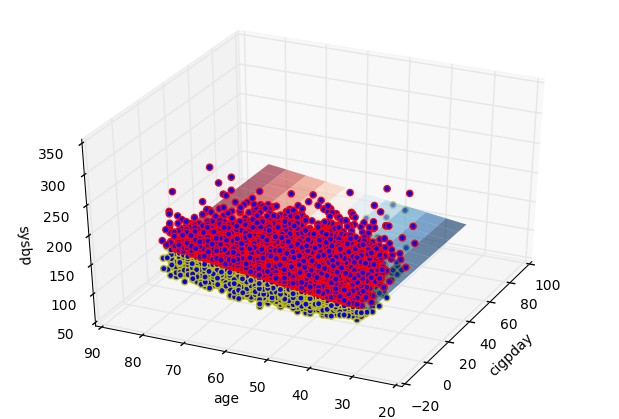

In [95]:
from mpl_toolkits.mplot3d import Axes3D

# Create 3D plot - rectangular grid
x_plt = np.linspace(cigpday.min(), cigpday.max(), 100)
y_plt = np.linspace(age.min(), age.max(), 100)
xx1, xx2 = np.meshgrid(x_plt, y_plt)

# hyperplane by evaluating the parameters on the grid
Z = results.params['Intercept'] + results.params['cigpday'] * xx1 + results.params['age'] * xx2

# Create matplotlib 3D axes
fig = plt.figure()
ax = Axes3D(fig, azim=-155, elev=35) # create 3D grid

# Plot hyperplane
surf = ax.plot_surface(xx1, xx2, Z, 
                       cmap=plt.cm.RdBu_r, 
                       alpha=0.6, linewidth=0)

# Plot data points
# points over the HP are red, points below are yellow
resid = sysbp - results.predict(clean_data[['cigpday', 'age']])
ax.scatter(clean_data[resid >= 0].cigpday, clean_data[resid >= 0].age, clean_data[resid >= 0].sysbp, 
           color='red', alpha=1.0, facecolor='red')
ax.scatter(clean_data[resid < 0].cigpday, clean_data[['cigpday', 'age']][resid < 0].age, 
           clean_data[resid < 0].sysbp, color='y', alpha=1.0)

# set axis labels
ax.set_xlabel('cigpday')
ax.set_ylabel('age')
ax.set_zlabel('sysbp')

## Goodness of Fit
Determine how well the model fits the data.

### Root Mean Squared Error (RMSE)
The root mean squared error is the *standard deviation of the residuals*. It's best used to quantify the strength of relationship between the predictor variables (`x`) and systolic blood pressure.

It measures the *absolute fit* of the model to the data. In other words, how close to the observed data points are the model's *predicted* values.

In [133]:
rmse = results.resid.std()
print "RMSE of sysbp (residual) = %.3f mmHg" % rmse

RMSE of sysbp (residual) = 20.970 mmHg


In [134]:
rmse2 = clean_data['sysbp'].std()
print "RMSE of sysbp (y) = %.3f mmHg" % rmse2

RMSE of sysbp (y) = 22.766 mmHg


In [135]:
print "[%3f, %3f]" % (sysbp.min(), sysbp.max())

[83.500000, 295.000000]


##### Conclusion
The RMSE of the model is approximately 20.97 mmHg. The RMSE is relatively small in comparison to the range of systolic blood pressure (*response*). Thus, the low RMSE value indicates a good fit for the model.

Comparing the standard deviation of the residuals against the systolic blood pressure (`ys`), it appears that knowing the predictor variables (`cigpday` & `age`), improves the model's predictions slightly (- 2 mmHg).

### Coefficient of (Multiple) Determination R<sup>2</sup>
The coefficient of determination quantifies the goodness of fit of the linear model to the data. More specifically, it demonstrates the quality of the model's prediction.

**Range**: [0, 1]

In [106]:
results.rsquared

0.15162982094079036

#### Conclusion
The R<sup>2</sup> value is 0.15, which indicates that using the predictor variables, `cigpday` and `age`, the model only predicts about 15% of variance in systolic blood pressure. Thus, the small coefficient value suggests that the proposed multiple linear regression model does not improve predictive power.

##### Limitations
R<sup>2</sup> as a metric has key limitations such as the inability to detrermine whether the coefficient estimates and predictions are biased.

It does not fully indicate whether a regression model is adequate either. A good model could have a low R<sup>2</sup> value and a poor model could have a high value.

## Model Improvement
The addition of other explanatory variables may improve the regression model in its prediction of systolic blood pressure. Though, adding variables that have little relationship with the response or those that are too closely related to one another could reduce the model's performance.

Feature selection is another approach to filter out insignificant predictors.

### Feature Selection
Determine if additional predictor variables (`x`) actually improve the regression model's performance in predicting systolic blood pressure (`y`).

###  Goodness of Fit: R<sup>2</sup>
#### Multiple Linear Regression: *`cigpday` + `age`*

In [142]:
print "R-squared = %f" % results.rsquared
print "Adjusted R-squared = %f" % results.rsquared_adj

R-squared = 0.151630
Adjusted R-squared = 0.151483


#### Simple Linear Regression: *`cigpday`*

In [143]:
cigpday_model = smf.ols(formula='sysbp ~ cigpday', data=clean_data)
cigpday_results = cigpday_model.fit()

cigpday_slope = cigpday_results.params['cigpday'],
cigpday_pval = cigpday_results.pvalues['cigpday']

print "R-squared = %f" % cigpday_results.rsquared
print "Adjusted R-squared = %f" % cigpday_results.rsquared_adj

R-squared = 0.010562
Adjusted R-squared = 0.010476


#### Simple Linear Regression: *`age`*

In [144]:
age_model = smf.ols(formula='sysbp ~ age', data=clean_data)
age_results = age_model.fit()

age_slope = age_results.params['age'],
age_pval = age_results.pvalues['age']

print "R-squared = %f" % age_results.rsquared
print "Adjusted R-squared = %f" % age_results.rsquared_adj

R-squared = 0.151417
Adjusted R-squared = 0.151343


##### Conclusion
  * The addition of `age` as a predictor, greatly improved the regression model's performance when it was only estimating parameters on the basis of `cigpday`. 
     * The R<sup>2</sup> value improved by .14.
        * R<sup>2</sup><sub>cigpday</sub> = 0.0106
        * R<sup>2</sup><sub>cigpday + age</sub> = 0.152

  * The addition of `cigpday` as a predictor did not improve the model's performance of predicting `sysbp`. As indicated by the results of the multiple regression model, `cigpday` was determined to not have much significance as an effect (controlling for `age`).
     * The R<sup>2</sup> value did not improve (approximately 0).
        * R<sup>2</sup><sub>age</sub> = 0.151
        * R<sup>2</sup><sub>cigpday + age</sub> = 0.152
        
##### Considerations
R<sup>2</sup> will always increase as you add features to the model, even if they are unrelated to the response. Thus, selecting the model wtih the highest R<sup>2</sup> value is not a reliable approach.

The **adjusted R<sup>2</sup>** should also be evaluated as it penalizes the model complexity, *controlling for overfitting*.